# Generate Push Object URDFs

In [62]:
import alphashape
import math
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point

def load_vertices(obj_file):
    vertices = []
    with open(obj_file, "r") as file:
        for line in file:
            if not line.startswith("v "):
                continue
            vertices.append(np.array(list(map(float, re.findall("[-]?\d+\.\d+", line)))))
    return np.array(vertices)

def visualize(vertices):
    plt.scatter(vertices[:,0], vertices[:,2], c='black', s=1)
    plt.axis("equal")
    plt.grid()
    
def generate_collision_points(vertices, resolution = 0.01, alpha = 0):
    min_x = np.min(vertices[:, 0])
    max_x = np.max(vertices[:, 0])
    min_y = np.min(vertices[:, 1])
    max_y = np.max(vertices[:, 1])
    min_z = np.min(vertices[:, 2])
    max_z = np.max(vertices[:, 2])
        
    def round_r(v):
        return math.floor(v / resolution) * resolution
    
    center_y = 0.5 * (min_y + max_y)
    diameter_y = max_y - min_y
    
    plt.figure(figsize=(8,8))
    visualize(vertices)
    
    
    # duplicate vertices and scale inside to improve alpha shape result
    vertices = np.concatenate([vertices, vertices * 0.7])
    # generate alpha shape (concave hull)
    alpha_shape = alphashape.alphashape(vertices[:, [0,2]], alpha)
    plt.gca().add_patch(PolygonPatch(alpha_shape, alpha=0.2))

    collision_points = []
    for x in np.arange(start=round_r(min_x) - resolution, stop=round_r(max_x) + resolution, step=resolution):
        for z in np.arange(start=round_r(min_z) - resolution, stop=round_r(max_z) + resolution, step=resolution):
            p = Point(x, z)
            if p.within(alpha_shape):
                plt.scatter([x], [z], c="r", s=2)
                collision_points.append(np.array([x, center_y, z]))
    plt.axis("equal")
    plt.grid()
    return collision_points

def generate_urdf(folder_name, obj_file, urdf_file, resolution = 0.01, alpha = 0):
    vertices = load_vertices(os.path.join(folder_name, obj_file))
    collision_points = generate_collision_points(vertices, resolution, alpha)
    min_y = np.min(vertices[:, 1])
    max_y = np.max(vertices[:, 1])
    diameter_y = max_y - min_y
    
    collision_urdf = ""
    for cp in collision_points:
        collision_urdf += """
        <collision>
          <origin rpy="0 0 0" xyz="%.4f %.4f %.4f"/>
          <geometry>
            <sphere radius="%.4f"/>
          </geometry>
        </collision>
        """ % (cp[0], cp[1], cp[2], diameter_y * 0.51)

    urdf = """<?xml version="1.0" ?>
<robot name="push_object">
  <link name="baseLink">
    <contact>
      <rolling_friction value="0.03"/>
      <spinning_friction value="0.03"/>
    </contact>

    <inertial>
      <origin rpy="0 0 0" xyz="0 0 0"/>
       <mass value="10.0"/>
       <inertia ixx="1" ixy="0" ixz="0" iyy="1" iyz="0" izz="1"/>
    </inertial>
    <visual>
      <origin rpy="0 0 0" xyz="0 0 0"/>
      <geometry>
        <mesh filename="%s" scale="1.0 1.0 1.0"/>      
      </geometry>
      <material name="gray">
        <color rgba="0.5 0.5 0.5 1"/>
        <specular rgb="1 1 1"/>
      </material>
    </visual>
    %s
  </link>
</robot>
""" % (obj_file, collision_urdf)

    with open(os.path.join(folder, urdf_file), "w") as file:
        file.write(urdf)

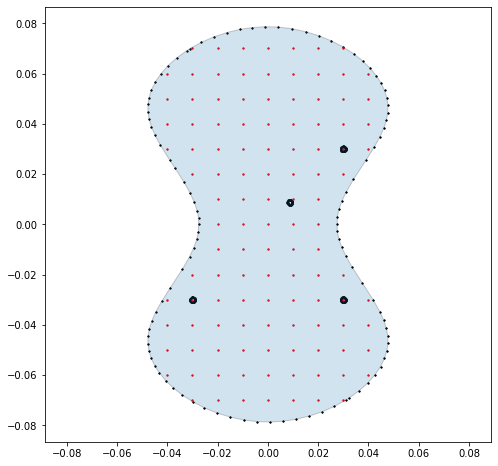

In [63]:
folder = "/home/eric/tiny-differentiable-simulator/data/mit-push/obj"
obj_file = "butter.obj"
urdf_file = "butter.urdf"
generate_urdf(folder, obj_file, urdf_file, resolution = 0.01, alpha = 50)

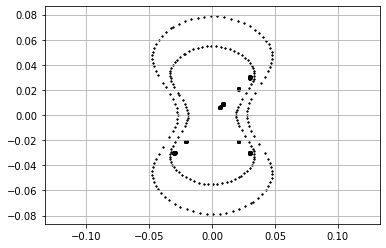

In [64]:
vertices = load_vertices(os.path.join(folder,obj_file))
vertices = np.concatenate([vertices, vertices * 0.7])
visualize(vertices)

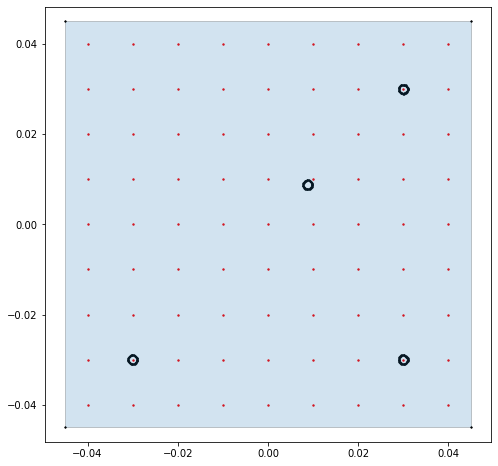

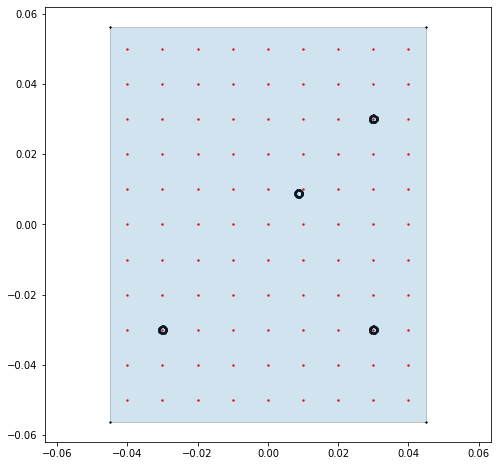

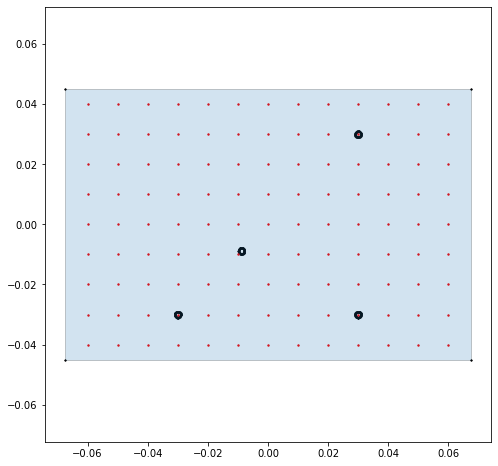

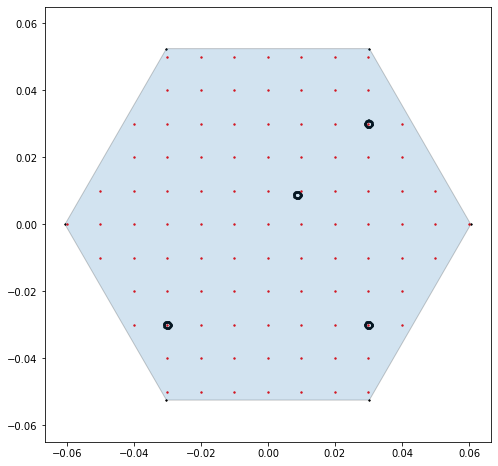

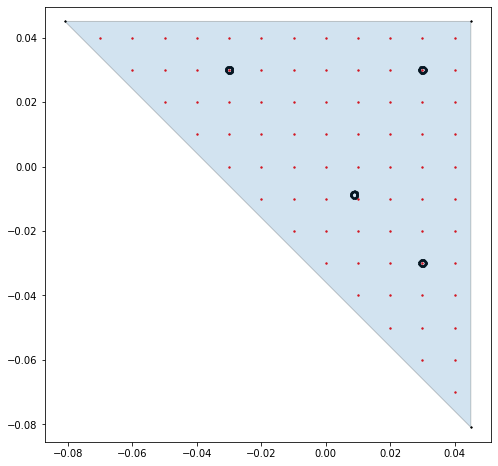

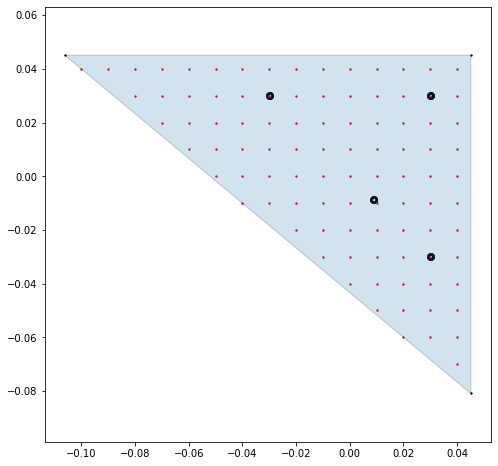

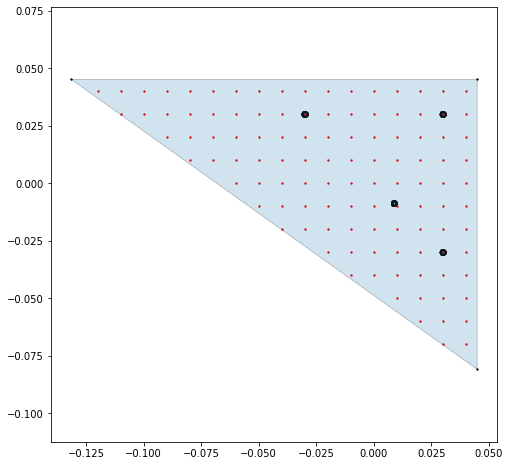

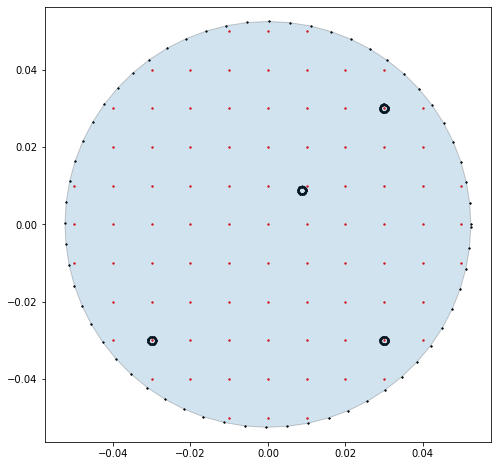

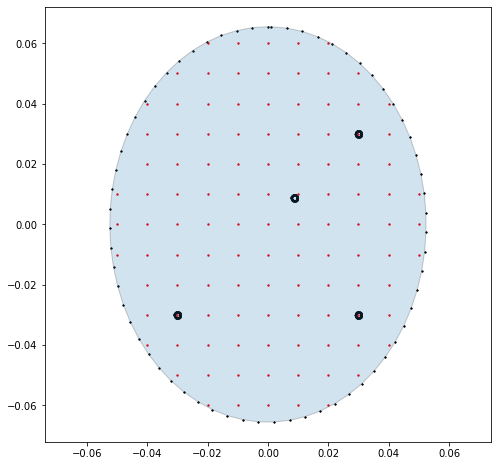

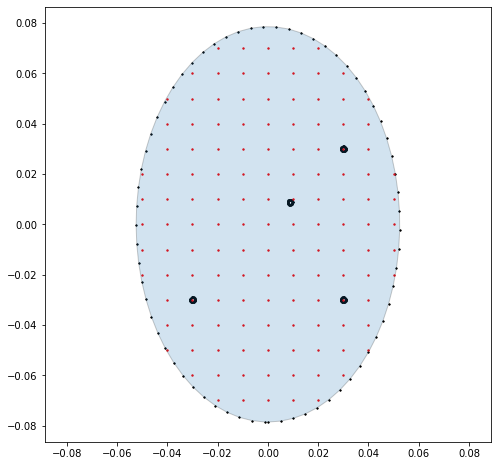

In [65]:
for obj in ("rect1", "rect2", "rect3", "hex", "tri1", "tri2", "tri3", "ellip1", "ellip2", "ellip3"):
    generate_urdf(folder, obj + ".obj", obj + ".urdf", resolution = 0.01, alpha = 0)  # just convex hull is sufficient